<img src='http://hilpisch.com/taim_logo.png' width="350px" align="right">

# AI-First Finance

**Classification for Market Prediction**

Dr Yves J Hilpisch | The AI Machine

http://aimachine.io | http://twitter.com/dyjh

## Imports

For the `tpqoa` package see http://github.com/yhilpisch/tpqoa.

In [ ]:
!git clone https://github.com/tpq-classes/ai_in_finance.git
import sys
sys.path.append('ai_in_finance')


In [ ]:
from fix_cufflink import *
cf_colors.to_rgba = fixed_to_rgba
cf_plotlytools.to_rgba = fixed_to_rgba

In [ ]:
!pip install git+https://github.com/yhilpisch/tpqoa

In [ ]:
import math
import tpqoa
import numpy as np
import pandas as pd
from pylab import plt
plt.style.use('seaborn-v0_8')

## Data

In [ ]:
symbol = 'EUR_USD'
start =  '2019-01-01'
end = '2019-03-27'
granularity = 'M10'
price = 'A'
# adjust path
fn = f'../../../data/oanda_{symbol}_{start}_{end}_{granularity}_{price}.csv'
fn

'../../../data/oanda_EUR_USD_2019-01-01_2019-03-27_M10_A.csv'

In [ ]:
%%time
try:
    raw = pd.read_csv(fn, index_col=0, parse_dates=True)
except:
    # adjust path
    api = tpqoa.tpqoa('../../../oanda.cfg')
    raw = api.get_history(symbol, start, end, granularity, price)
    raw.to_csv(fn)

CPU times: user 17.6 ms, sys: 4.29 ms, total: 21.9 ms
Wall time: 29.9 ms


In [ ]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8654 entries, 2019-01-01 22:00:00 to 2019-03-26 23:50:00
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   o         8654 non-null   float64
 1   h         8654 non-null   float64
 2   l         8654 non-null   float64
 3   c         8654 non-null   float64
 4   volume    8654 non-null   int64  
 5   complete  8654 non-null   bool   
dtypes: bool(1), float64(4), int64(1)
memory usage: 414.1 KB


In [ ]:
data = pd.DataFrame(raw['c'])
data.columns = [symbol]
data['r'] = np.log(data[symbol] / data[symbol].shift(1))
data['d'] = np.where(data['r'] > 0, 1, 0)
data.dropna(inplace=True)

In [ ]:
ld = len(data)
ld

8653

In [ ]:
split = int(ld * 0.6)
split

5191

In [ ]:
val_size = int(ld * 0.1)
val_size

865

In [ ]:
train = data.iloc[:split].copy().sort_index()
val = train.iloc[-val_size:].copy().sort_index()
train = train.iloc[:-val_size].copy().sort_index()
test = data.iloc[split:].copy().sort_index()

In [ ]:
lags = 10

In [ ]:
def create_lags(df, mu, std):
    global cols
    cols = []
    bins = [mu - std, mu - std / 2, mu, mu + std, mu + std]
    df['o'] = np.digitize(df['r'], bins)
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        df[col] = df['o'].shift(lag)
        cols.append(col)
    df.dropna(inplace=True)
    df[cols] = df[cols].astype(int)

In [ ]:
mu = train['r'].mean()
std = train['r'].std()
create_lags(train, mu, std)

In [ ]:
train.head(5)

,EUR_USD,r,d,o,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
time,,,,,,,,,,,,,,
2019-01-01 23:50:00,1.14622,-0.000061,0,2,0,2,2,3,2,3,1,3,3,2
2019-01-02 00:00:00,1.14620,-0.000017,0,2,2,0,2,2,3,2,3,1,3,3
2019-01-02 00:10:00,1.14617,-0.000026,0,2,2,2,0,2,2,3,2,3,1,3
2019-01-02 00:20:00,1.14590,-0.000236,0,1,2,2,2,0,2,2,3,2,3,1
2019-01-02 00:30:00,1.14558,-0.000279,0,1,1,2,2,2,0,2,2,3,2,3


In [ ]:
create_lags(val, mu, std)

In [ ]:
val.head()

,EUR_USD,r,d,o,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
time,,,,,,,,,,,,,,
2019-02-13 01:00:00,1.13360,0.000662,1,5,2,1,2,1,3,2,2,1,2,3
2019-02-13 01:10:00,1.13344,-0.000141,0,2,5,2,1,2,1,3,2,2,1,2
2019-02-13 01:20:00,1.13363,0.000168,1,3,2,5,2,1,2,1,3,2,2,1
2019-02-13 01:30:00,1.13332,-0.000273,0,1,3,2,5,2,1,2,1,3,2,2
2019-02-13 01:40:00,1.13325,-0.000062,0,2,1,3,2,5,2,1,2,1,3,2


In [ ]:
create_lags(test, mu, std)

In [ ]:
test.head()

,EUR_USD,r,d,o,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
time,,,,,,,,,,,,,,
2019-02-21 01:30:00,1.13364,-0.000053,0,2,1,1,2,1,2,3,2,2,2,3
2019-02-21 01:40:00,1.13361,-0.000026,0,2,2,1,1,2,1,2,3,2,2,2
2019-02-21 01:50:00,1.13352,-0.000079,0,2,2,2,1,1,2,1,2,3,2,2
2019-02-21 02:00:00,1.13369,0.000150,1,3,2,2,2,1,1,2,1,2,3,2
2019-02-21 02:10:00,1.13366,-0.000026,0,2,3,2,2,2,1,1,2,1,2,3


## MLP Classifier

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
model = MLPClassifier(hidden_layer_sizes=(128, 128, 128),
                      activation='relu',
                      learning_rate_init=0.001,
                      random_state=100,
                      max_iter=500,
                      validation_fraction=0.1,
                      shuffle=False,
                      early_stopping=False,
                      verbose=False)

In [ ]:
%time model.fit(train[cols], train['d'], verbose=0)

In [ ]:
model(tf.convert_to_tensor(test[cols], dtype=tf.float32), training=False).numpy()

In [ ]:
test['p'] = model(tf.convert_to_tensor(test[cols], dtype=tf.float32), training=False).numpy()
test['p'] = np.where(test['p'] > 0, 1, -1)

In [ ]:
test['s'] = test['p'] * test['r']

In [ ]:
test[['r', 's']].sum().apply(np.exp)

r    0.994522
s    1.011266
dtype: float64

In [ ]:
sum(test['p'].diff() != 0)

1679

In [ ]:
test['p'].value_counts()

p
 1    1927
-1    1525
Name: count, dtype: int64

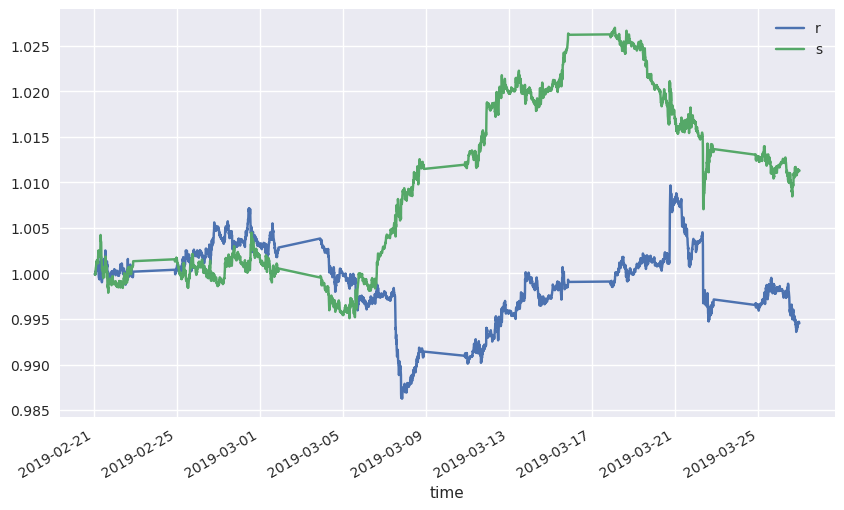

In [ ]:
test[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6));

## No Regularization

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

E0000 00:00:1744101104.669143 1056985 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744101104.677903 1056985 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744101104.698959 1056985 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744101104.699017 1056985 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744101104.699021 1056985 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744101104.699025 1056985 computation_placer.cc:177] computation placer already registered. Please check linka

In [ ]:
np.random.seed(100)
tf.random.set_seed(100)

In [ ]:
model = Sequential()

model.add(Dense(128, activation='sigmoid', input_shape=(lags,)))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

/anaconda/envs/numpy-1.26.4/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
%%time
model.fit(train[cols], train['d'],
          epochs=150, batch_size=32, verbose=False,
          validation_data=(val[cols], val['d']));

CPU times: user 1min 14s, sys: 5.81 s, total: 1min 20s
Wall time: 1min 21s


In [ ]:
res = pd.DataFrame(model.history.history)

In [ ]:
res.tail(3)

,accuracy,loss,val_accuracy,val_loss
147,0.588508,0.663529,0.523977,0.714720
148,0.589203,0.663222,0.523977,0.714948
149,0.589203,0.662912,0.523977,0.715181


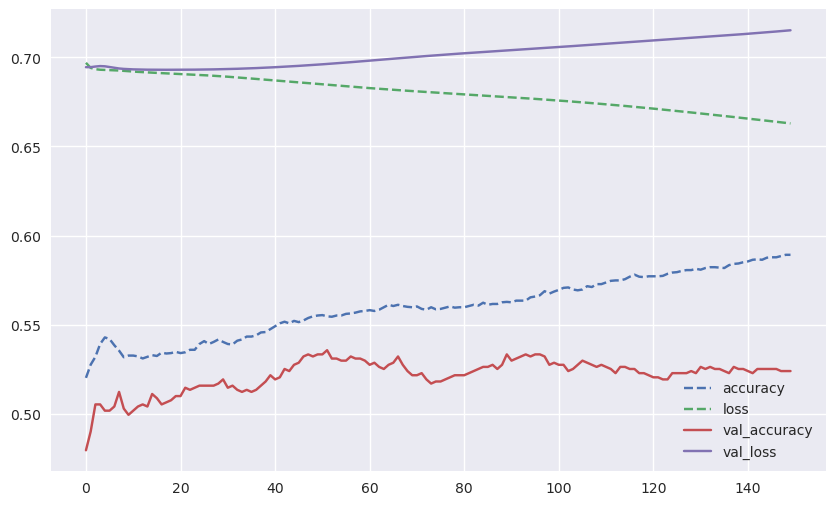

In [ ]:
res.plot(figsize=(10, 6), style=['--', '--', '-', '-']);

In [ ]:
model.evaluate(test[cols], test['d'])

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5181 - loss: 0.7117


[0.7103879451751709, 0.5246233940124512]

In [ ]:
model(tf.convert_to_tensor(test[cols], dtype=tf.float32), training=False).numpy()

In [ ]:
test['p'] = np.where(model(tf.convert_to_tensor(test[cols], dtype=tf.float32), training=False).numpy() > 0.5, 1, 0)
test['p'] = np.where(test['p'] > 0, 1, -1)

In [ ]:
test['s'] = test['p'] * test['r']

In [ ]:
test[['r', 's']].sum().apply(np.exp)

r    0.994522
s    1.023970
dtype: float64

In [ ]:
sum(test['p'].diff() != 0)

1094

In [ ]:
test['p'].value_counts()

p
-1    2166
 1    1286
Name: count, dtype: int64

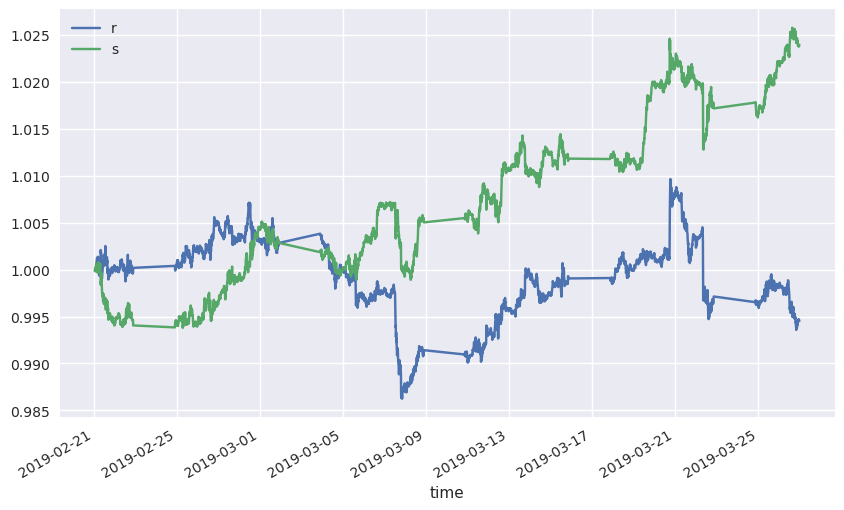

In [ ]:
test[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6));

## With Kernel Regularizer

In [ ]:
from keras.regularizers import l1, l2

In [ ]:
np.random.seed(100)
tf.random.set_seed(100)

In [ ]:
model = Sequential()

model.add(Dense(128, activation='relu',
                kernel_regularizer=l2(0.001),
                input_shape=(lags,)))
model.add(Dense(128, activation='relu',
               kernel_regularizer=l2(0.001)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

/anaconda/envs/numpy-1.26.4/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
%%time
model.fit(train[cols], train['d'],
          epochs=125, batch_size=32, verbose=False,
          validation_data=(val[cols], val['d']));

CPU times: user 1min 2s, sys: 4.69 s, total: 1min 6s
Wall time: 1min 4s


In [ ]:
res = pd.DataFrame(model.history.history)

In [ ]:
res.tail(3)

,accuracy,loss,val_accuracy,val_loss
122,0.692308,0.610488,0.512281,0.830855
123,0.691613,0.609725,0.513450,0.833163
124,0.691844,0.608735,0.506433,0.835455


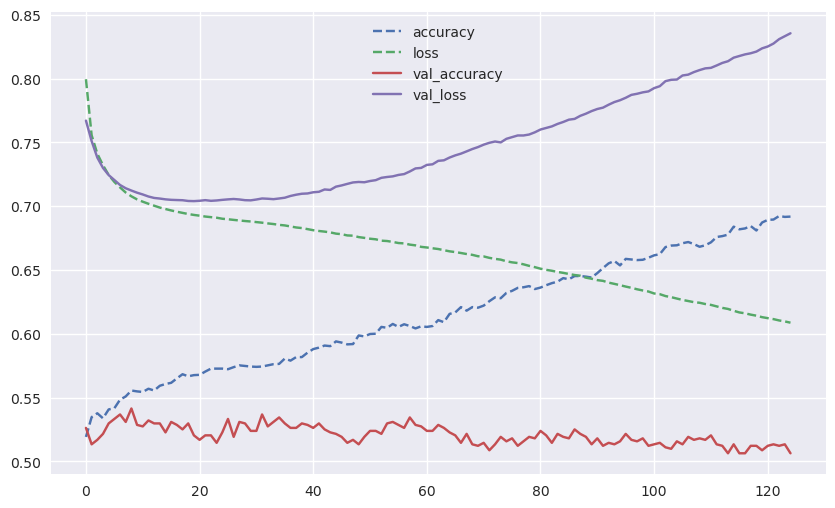

In [ ]:
res.plot(figsize=(10, 6), style=['--', '--', '-', '-']);

In [ ]:
model.evaluate(test[cols], test['d'])

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5058 - loss: 0.8259


[0.8293105959892273, 0.5052143931388855]

In [ ]:
test['p'] = np.where(model(tf.convert_to_tensor(test[cols], dtype=tf.float32), training=False).numpy() > 0.5, 1, 0)
test['p'] = np.where(test['p'] > 0, 1, -1)

In [ ]:
test['s'] = test['p'] * test['r']

In [ ]:
test[['r', 's']].sum().apply(np.exp)

r    0.994522
s    0.996588
dtype: float64

In [ ]:
sum(test['p'].diff() != 0)

1395

In [ ]:
test['p'].value_counts()

p
-1    2147
 1    1305
Name: count, dtype: int64

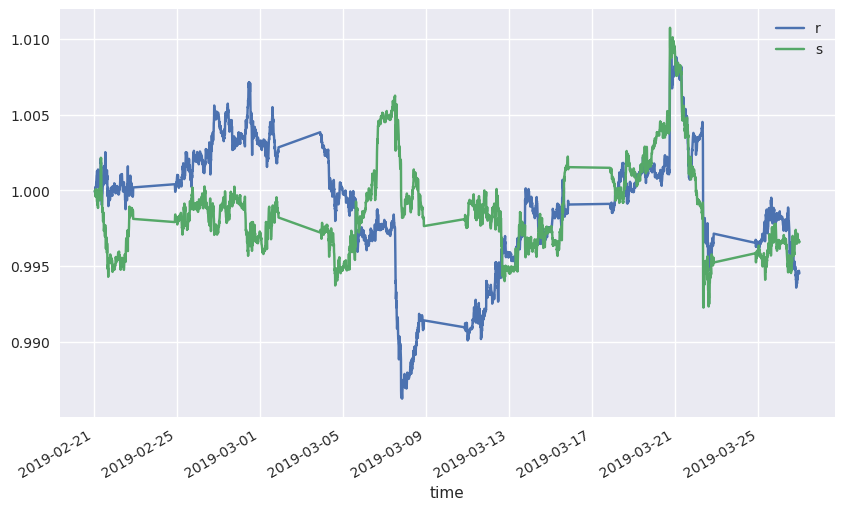

In [ ]:
test[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6));

## With Dropout

In [ ]:
from keras.layers import Dropout

In [ ]:
np.random.seed(100)
tf.random.set_seed(100)

In [ ]:
model = Sequential()

model.add(Dense(128, activation='relu',
                input_shape=(lags,)))
model.add(Dropout(0.3, seed=100))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3, seed=100))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

/anaconda/envs/numpy-1.26.4/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
%%time
model.fit(train[cols], train['d'],
          epochs=125, batch_size=32, verbose=False,
          validation_data=(val[cols], val['d']));

CPU times: user 1min 12s, sys: 5.31 s, total: 1min 17s
Wall time: 1min 42s


In [ ]:
res = pd.DataFrame(model.history.history)

In [ ]:
res.tail(3)

,accuracy,loss,val_accuracy,val_loss
122,0.675626,0.577420,0.497076,0.839065
123,0.666589,0.580758,0.497076,0.844489
124,0.673540,0.576390,0.483041,0.855013


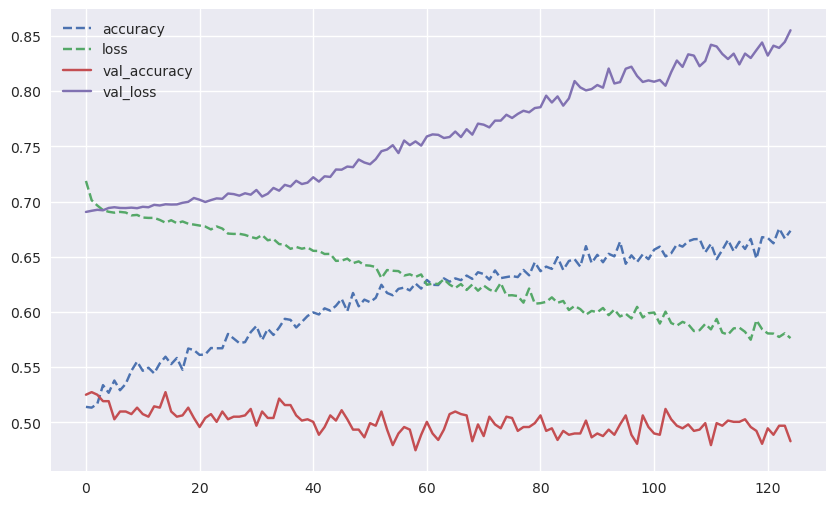

In [ ]:
res.plot(figsize=(10, 6), style=['--', '--', '-', '-']);

In [ ]:
model.evaluate(test[cols], test['d'])

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5113 - loss: 0.8082


[0.7983421087265015, 0.5136153101921082]

In [ ]:
test['p'] = np.where(model(tf.convert_to_tensor(test[cols], dtype=tf.float32), training=False).numpy() > 0.5, 1, 0)
test['p'] = np.where(test['p'] > 0, 1, -1)

In [ ]:
test['s'] = test['p'] * test['r']

In [ ]:
test[['r', 's']].sum().apply(np.exp)

r    0.994522
s    1.015093
dtype: float64

In [ ]:
sum(test['p'].diff() != 0)

1490

In [ ]:
test['p'].value_counts()

p
-1    2064
 1    1388
Name: count, dtype: int64

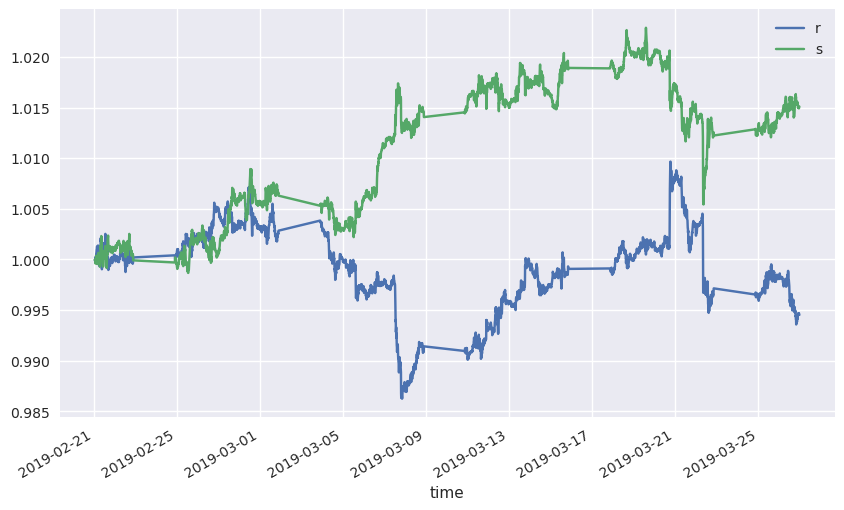

In [ ]:
test[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6));

## Early Stopping

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
np.random.seed(100)
tf.random.set_seed(100)

In [ ]:
model = Sequential()

model.add(Dense(128, activation='relu',
                input_shape=(lags,)))
model.add(Dropout(0.3, seed=100))
model.add(Dense(128, activation='relu',
               ))
model.add(Dropout(0.3, seed=100))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

/anaconda/envs/numpy-1.26.4/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
callbacks = [EarlyStopping(monitor='val_accuracy', patience=20)]

In [ ]:
%%time
model.fit(train[cols], train['d'],
          epochs=250,
          batch_size=32,
          verbose=False,
          validation_data=(val[cols], val['d']),
          callbacks=callbacks);

CPU times: user 18.7 s, sys: 1.35 s, total: 20.1 s
Wall time: 29.3 s


In [ ]:
res = pd.DataFrame(model.history.history)

In [ ]:
res.tail(3)

,accuracy,loss,val_accuracy,val_loss
25,0.560936,0.676643,0.518129,0.700850
26,0.552827,0.676849,0.504094,0.703487
27,0.570204,0.676370,0.505263,0.704029


In [ ]:
res.val_accuracy.max()

0.5286549925804138

<Axes: >

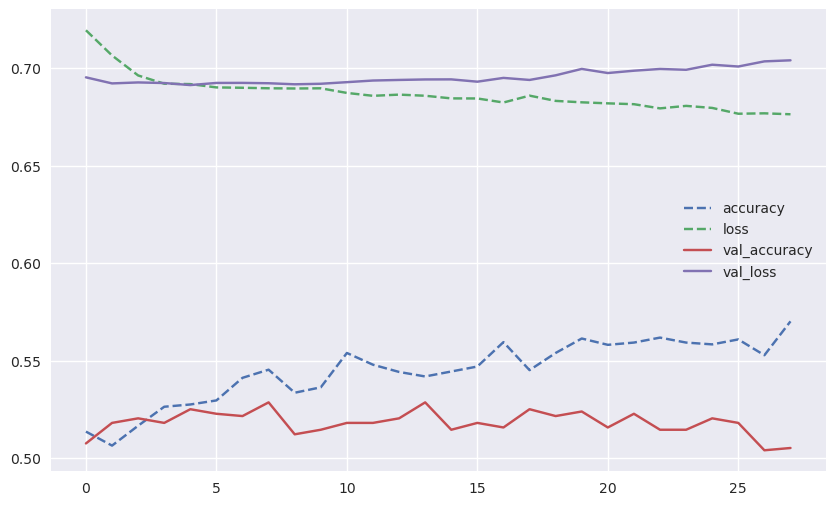

In [ ]:
res.plot(figsize=(10, 6), style=['--', '--', '-', '-'])

In [ ]:
model.evaluate(test[cols], test['d'])

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5139 - loss: 0.6997


[0.6987965106964111, 0.5173812508583069]

In [ ]:
test['p'] = np.where(model(tf.convert_to_tensor(test[cols], dtype=tf.float32), training=False).numpy() > 0.5, 1, 0)
test['p'] = np.where(test['p'] > 0, 1, -1)

In [ ]:
test['s'] = test['p'] * test['r']

In [ ]:
test[['r', 's']].sum().apply(np.exp)

r    0.994522
s    1.016895
dtype: float64

In [ ]:
sum(test['p'].diff() != 0)

1292

In [ ]:
test['p'].value_counts()

p
-1    2313
 1    1139
Name: count, dtype: int64

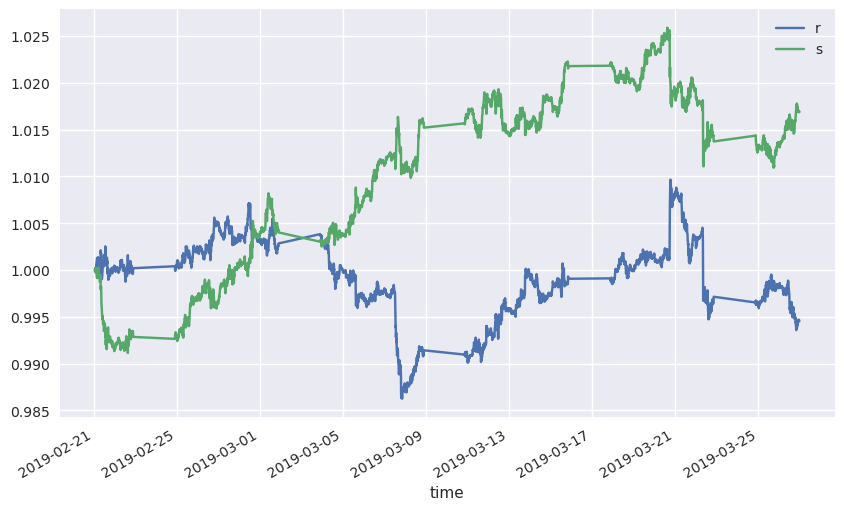

In [ ]:
test[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6));

## Best Weights (Validation)

In [ ]:
np.random.seed(100)
tf.random.set_seed(100)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# adjust path
callbacks = [ModelCheckpoint(filepath='../../../data/.weights.h5',
                             monitor='val_accuracy',
                             verbose=0,
                             save_best_only=True,
                             save_weights_only=True,
                             mode='auto',
                             save_freq=1)]

In [ ]:
%%time
model.fit(train[cols], train['d'],
          epochs=100,
          batch_size=32,
          verbose=False,
          validation_data=(val[cols], val['d']),
          callbacks=callbacks);

ValueError: Could not interpret metric identifier: val_accuracy

In [ ]:
# adjust path
model.load_weights('../../../data/.weights.h5')

ValueError: A total of 2 objects could not be loaded. Example error message for object <Dense name=dense_9, built=True>:

The shape of the target variable and the shape of the target value in `variable.assign(value)` must match. variable.shape=(10, 128), Received: value.shape=(50, 128). Target variable: <Variable path=sequential_3/dense_9/kernel, shape=(10, 128), dtype=float32, value=[[ 0.00139974  0.17178869 -0.09260054 ...  0.3084552  -0.31163448
  -0.3249303 ]
 [ 0.16003081  0.19696775  0.16232643 ... -0.04047891 -0.10395082
   0.13927959]
 [ 0.14454226  0.05126222 -0.0520413  ...  0.13548954  0.08453064
  -0.8072153 ]
 ...
 [-0.3580885  -0.17804877  0.14822508 ...  0.1148049   0.10282516
  -0.03804714]
 [ 0.1652965  -0.0223335  -0.30893302 ... -0.01862605 -0.26364732
  -0.278625  ]
 [-0.307783    0.06318311 -0.3410606  ... -0.16381462  0.34987402
  -0.07481215]]>

List of objects that could not be loaded:
[<Dense name=dense_9, built=True>, <keras.src.optimizers.adam.Adam object at 0x7f4c3f8b1ff0>]

In [ ]:
model.evaluate(test[cols], test['d'])

In [ ]:
test['p'] = np.where(model(tf.convert_to_tensor(test[cols], dtype=tf.float32), training=False).numpy() > 0.5, 1, 0)
test['p'] = np.where(test['p'] > 0, 1, -1)

In [ ]:
test['s'] = test['p'] * test['r']

In [ ]:
test[['r', 's']].sum().apply(np.exp)

In [ ]:
sum(test['p'].diff() != 0)

In [ ]:
test['p'].value_counts()

In [ ]:
test[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6));

<img src='http://hilpisch.com/taim_logo.png' width="350px" align="right">